# Import libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
from __future__ import print_function
import math
from sklearn.metrics import f1_score,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import numpy as np

The main used libraries include sklearn, matplotlib, pandas, numpy and lime.

# Data Ingestion & Preparation

## Data collection 

In [2]:
datasets_1 = np.genfromtxt('./Data/adult.data', delimiter=', ', dtype=str)
datasets_2 = np.genfromtxt('./Data/adult.test', delimiter=', ', dtype=str,autostrip = True )
for i, n in enumerate(datasets_2[:,14]):
    datasets_2[i,14] = n.strip('.') 
feature_and_labels_names=["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", 
                 "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week","Country","income"]

alldata =np.concatenate((datasets_1, datasets_2), axis=0)

df = pd.DataFrame(alldata,columns=feature_and_labels_names)                         


## Data preparation 

In [3]:
from numpy import unique
for i in range(alldata.shape[1]):
    if len(unique(alldata[:, i])) <=1:
           print(i)
    else:
           print(i, len(unique(alldata[:, i])))



0 74
1 9
2 28523
3 16
4 16
5 7
6 15
7 6
8 5
9 2
10 123
11 99
12 96
13 42
14 2


This steps shows kinds of value of each feature.

In [4]:
print(df.shape)
for a in feature_and_labels_names:
    df = df[df[a].str.contains('\?') == False]

print(df.shape)
df.drop_duplicates() 
df.dropna()
df.isnull().sum()
print(df.shape)



(48842, 15)
(45222, 15)
(45222, 15)


Missing values are removed,and duplicated rows are removed

0         77516
1         83311
2        215646
3        234721
4        338409
          ...  
48836    245211
48837    215419
48839    374983
48840     83891
48841    182148
Name: fnlwgt, Length: 45222, dtype: int32


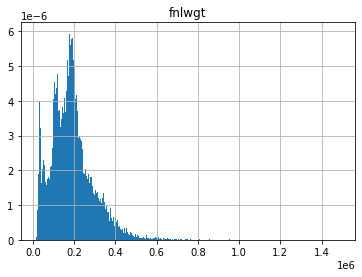

In [5]:
df['fnlwgt']=df['fnlwgt'].astype(str).astype(int)
print(df['fnlwgt'])
ax=df.hist(column=['fnlwgt'],density=True,bins=500)


Visuallizing the disturibution of value of feature-Human weight

(44995, 15)


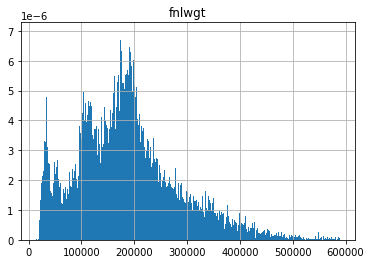

In [6]:
q_hi = df["fnlwgt"].quantile(0.995)
df = df[(df["fnlwgt"] < q_hi)]
ax=df.hist(column=['fnlwgt'],density=True,bins=500)
print(df.shape)

Removing outliers 

In [7]:
df=df.drop('Education-Num',axis = 1) 
np.random.seed(5)
data = df.to_numpy()
np.random.shuffle(data)
y = data[:,-1]
data =np.delete(data,[13],axis = 1)

 Feature selection is done in this step that Education-num is deleted for the repetition.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

categorical_features=[0,1,3,4,5,6,7,8,12]
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_


t = [('cat', OneHotEncoder(),[0,1,3,4,5,6,7,8,12]),('num',MinMaxScaler(),
            [2,9,10,11])]

transformer = ColumnTransformer(transformers=t)
le= LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_
data = data.astype(float)

data_1 = data[0:3000]
y_1 = y[0:3000]

Data transform is taken in this step. Both categorical and neumerical features are transformed.

In [9]:
train, test, labels_train, labels_test = train_test_split(data_1,y_1,train_size=0.80,random_state=1)
transformer.fit(data)
Encoded_train = transformer.transform(train)

Data split is done in this step with a ratio of  8:2 randomly 

## Model Building

In [10]:
# from sklearn.metrics import f1_score
# from sklearn.neural_network import MLPClassifier
# mlp_qs=MLPClassifier(max_iter=2000)
# parameter_space ={
#     'hidden_layer_sizes': [(5,),(10,),(15,),(20,),(40,)],
#     'activation':['tanh','relu'],
#     'solver':['sgd'],
#     'alpha':[0.001,0.005,0.01],
#     }
# #  'learning_rate':['constant,'adaptive'],
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(mlp_qs,parameter_space,n_jobs=-1,cv = 2)
# clf.fit(Encoded_train,labels_train)

Grid reseach is done in this step to find the best hyper-parameters for neural networks. The best parameter is "hidden_layer_sizes=(15,), random_state=3,max_iter=500, activation='relu',alpha =0.001,solver='sgd'"

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(15,), random_state=3,max_iter=1000,
                   activation='relu',alpha =0.001,solver='sgd')
clf.fit(Encoded_train, labels_train)
y_true = clf.predict(transformer.transform(test))
predict_fn = lambda x: clf.predict_proba(transformer.transform(x)).astype(float)
print(f1_score(y_true, labels_test, average='macro'))
accuracy_score(y_true, labels_test)

0.7314746710564721


0.8083333333333333

This is the model performance for the classifer f. 

# Building feature-based explainer

## Building explainer 

In [12]:
import lime
import lime.lime_tabular
feature_names=["Age", "Workclass", "fnlwgt", "Education", "Marital Status","Occupation", 
                 "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week","Country"]

explainer = lime.lime_tabular.LimeTabularExplainer(data,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
         
                                                   categorical_names=categorical_names)

## Generating explaination example

In [13]:
a=np.arange(5) #Generating 5 examples.
# a = [5]
for i in a:
    b = explainer.explain_instance(data_1[i],predict_fn, num_features=5, top_labels=1)
    b.show_in_notebook(predict_proba=True,show_predicted_value=True)
    b.save_to_file('./Downloads/lime.html')

#     a.savefig('./Downloads/explainationinstance.png',dpi=450,bbox_inches = 'tight')
#save_to_file('./Downloads/lime.html')
#  as_pyplot_figure 
# savefig('./Downloads/featureaverageimportance.png',dpi=450,bbox_inches = 'tight')

# Feature importance calculation and feature selection with XAI

In [14]:
import numpy as np
A=np.arange(len(data_1))


firkeys = [i for i in list(range(13))]
fir ={}
for i in range(len(firkeys)):
    fir[i]=[]


for i in A:
    b = explainer.explain_instance(data_1[i],predict_fn, num_features=5, top_labels=1)
    for v in b.local_exp:
        g=b.local_exp[v]
        d = np.asarray(g) 
    for n,i in d:
        fir[n].append(abs(i))
        
np.save('data/classfir.npy',fir)


In [14]:
fir =np.load('data/classfir.npy',allow_pickle=True).item()
d = []
l = []

for values in fir.values():
    l.append(len(values))
    d.append(values)

Generating feature-based explanations for all instances and aggregating them to get global feature importance.

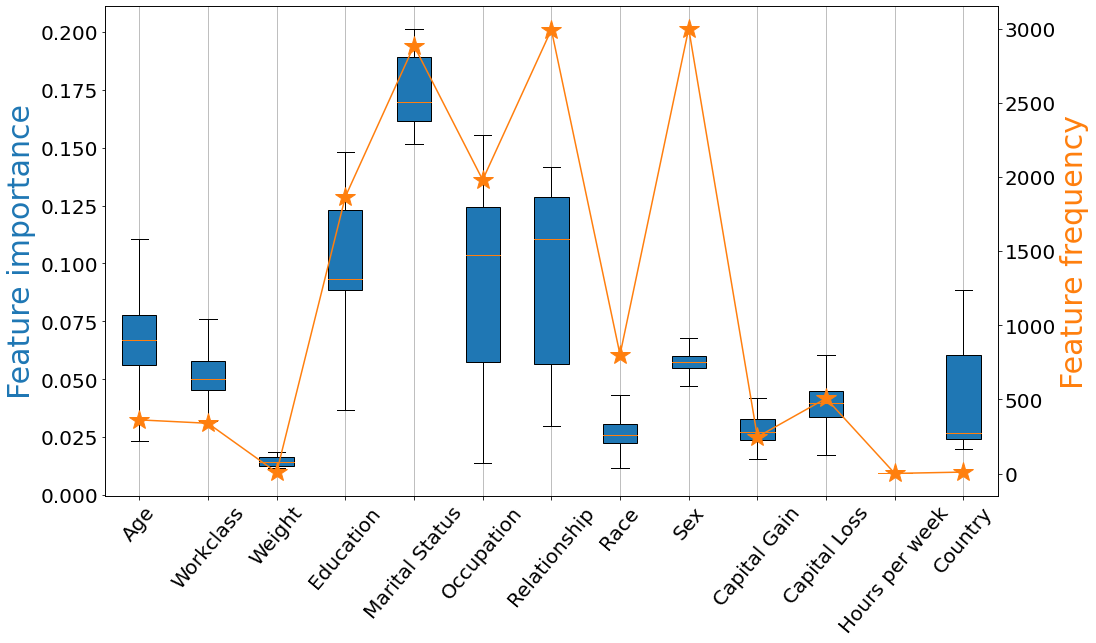

In [16]:
fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (16,9)
labels = ["Age", "Workclass", "Weight", "Education",  "Marital Status","Occupation", 
                 "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week","Country"]
x = np.arange(len(labels))
ax.boxplot(d,labels = labels,showfliers = False,patch_artist=True,positions =x)
ax.set_ylabel('Feature importance',fontsize = 30,color='C0')
ax.grid(axis='x')
plt.xticks(fontsize =20,rotation = 50)
plt.yticks(fontsize=20)

ax1=ax.twinx()
ax1.plot(x,l,color = 'C1',marker='*',ms=20)
ax1.set_ylabel('Feature frequency',fontsize = 30,color='C1')
plt.yticks(fontsize=20)
plt.show()
fig.figure.savefig('./Downloads/featureaverageimportance.jpg',dpi=600,bbox_inches = 'tight')


Drawing figure for feature importance, including error, average importance and frequency of top five feaure importance at each local explanation.It is apparent that the features of weight and hours per week are unimportant.

In [17]:
data_2 = np.delete(data_1,[2,11],axis = 1)
data = np.delete(data,[2,11],axis = 1)
r_train, r_test, r_labels_train, r_labels_test = train_test_split(data_2,y_1,train_size=0.80,
                                                          random_state=1)
x = [('cat', OneHotEncoder(),[0,1,2,3,4,5,6,7,10]),('num',MinMaxScaler(),
            [8,9])]
r_transformer = ColumnTransformer(transformers=x)
r_transformer.fit(data)
Encoded_r_train = r_transformer.transform(r_train)


Based on the figure above, two features are removed(Weight and hours per week) and then data is updated.

In [18]:
from sklearn.metrics import accuracy_score
clf1 = MLPClassifier(hidden_layer_sizes=(15,), random_state=3,max_iter=1000,
                   activation='relu',alpha =0.001,solver='sgd')
clf1.fit(Encoded_r_train, r_labels_train)
r_y_true = clf1.predict(r_transformer.transform(r_test))
print(f1_score(r_y_true, labels_test, average='macro'))
print(accuracy_score(r_y_true, labels_test))

0.7304157273257555
0.81


The updated data is used to retrain the model(classifier fa). The performance is measured by Macro-F1 and Accuracy.

# Data-based explanation 

## Data preparation

In [19]:
x1 = data[3000:18000]
x2 = data[18000:33000]
y1 = y[3000:18000]
y2 = np.random.randint(0,2,size=15000)
print(y2.shape,y1.shape)
x =np.concatenate((x1,x2),axis=0)

y =np.concatenate((y1,y2),axis =0)

x = x.reshape(30,1000,11)
y = y.reshape(30,1000,)

datakeys = [str(i) for i in list(range(30))]
datavalue ={}
for i in range(len(datakeys)):
    datavalue[i]=[0,0]


(15000,) (15000,)


30000 data instances are sampled from the remaining data, and the label of 15000 instances are changed randomly, that is corrupted.

## Building data-based explainer 

In [20]:
def accuracy(x,y,mode):
    classifier =MLPClassifier(hidden_layer_sizes=(15,), random_state=3,max_iter=1000,
                   activation='relu',alpha =0.001,solver='sgd')
    encodedtrain = r_transformer.transform(x)
    if mode == 1:
        classifier.partial_fit(encodedtrain,y, classes=list(range(2))) # Gradient-based method
    elif mode == 0:
        classifier.fit(encodedtrain,y)  # retrain the model
    r_y_true = classifier.predict(r_transformer.transform(r_test))
    accuracy = f1_score(r_y_true, labels_test, average='micro') # f1  micro accuracy = accuracy
    macro = f1_score(r_y_true, labels_test, average='macro')
    a = [accuracy,macro]     
    return a

inicial_accuracy =accuracy(r_train,r_labels_train,0)
def data_value(x,y,test=r_train,label=r_labels_train):
    metric = [0,0]
    each_accuracy=[inicial_accuracy]
    data_i = test
    y_1 = r_labels_train
    for i in np.random.permutation(len(x)): # Monte-Carlo method
        data_i =  np.concatenate((data_i,x[i]), axis=0)
        y_1 = np.concatenate((y_1,y[i]), axis=0)
        each_accuracy.append(accuracy(data_i,y_1,1))
        metric = np.array(each_accuracy[-1])-np.array(each_accuracy[-2]) 
        datavalue[i][0] += metric[0]
        datavalue[i][1] += metric[1]
    pass

# Calculating the marginal contribution of each data group

In [21]:
### Reaching convergence 
n= 300
# each_turn_data=[]
for j in range(n):
    data_value(x,y)

### Caculating the average value 
group_value =[]
for i in range(len(x)):
    group_value.append(np.array(datavalue[i]).astype(float)/n)
    

In [21]:
### Saving results
# np.save('data\group_value.npy',group_value)



In [22]:
### Reading data value
group_value = np.load('data/group_value.npy',allow_pickle=True)

In [17]:
### Separating high value from low value
high_value_data=[]
low_value_data=[]
aver_value = np.array(group_value)
for i in range(30):
    if aver_value[i,0] >= 0.000:
            
        high_value_data.append(i)
        print(aver_value[i][0]) #high data importance value
    elif aver_value[i,0] <= -0.01:
        low_value_data.append(i)
        print(aver_value[i][0]) #adverse data importance value

### Showing each data number 
print(high_value_data) #high value group number
print(low_value_data) #adverse value group number


0.017661111111111096
0.0056888888888888675
0.012161111111111065
0.005483333333333319
0.013494444444444429
0.012761111111111088
0.008844444444444417
0.014466666666666636
0.0030388888888888714
0.010111111111111092
0.010955555555555527
0.00829999999999999
0.002622222222222205
0.010738888888888874
0.008299999999999983
-0.01563888888888888
-0.016244444444444454
-0.021688888888888862
-0.01418888888888889
-0.01361666666666667
-0.012866666666666672
-0.013305555555555541
-0.02439444444444442
-0.026522222222222232
-0.022800000000000018
-0.03447777777777779
-0.023666666666666697
-0.026816666666666683
-0.020183333333333338
-0.024916666666666695
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


The result shows that corrupted groups are assigned negative value, whereas useful data groups are assigned high value 

## Further validation by retraining model with adverse data and valuable data

In [23]:
### Tranining with valuable datasets

ma=[]
va=[]
for m in range(200): # random 200 times retrain the model (different permutation of data feeding order)
    data_i = r_train
    y_1 = r_labels_train
    valuable_macro =[accuracy(r_train,r_labels_train,0)[1]]
    valuable_accuracy = [accuracy(r_train,r_labels_train,0)[0]]
    for i in np.random.permutation(high_value_data):
        data_i = np.concatenate((data_i,x[i]), axis=0)
        y_1 = np.concatenate((y_1,y[i]), axis=0)
        macro=accuracy(data_i,y_1,0)[1]
        accu = accuracy(data_i,y_1,0)[0]
        valuable_macro.append(macro)
        valuable_accuracy.append(accu)
    ma.append(valuable_macro)
    va.append(valuable_accuracy)

    
l_ma=[]
l_va=[]

### Training with adverse-value data
for k in range(200): # random 200 times retrain the model (different permutation of data feeding order)
    data_i = r_train
    y_1 = r_labels_train
    adverse_macro =[accuracy(r_train,r_labels_train,0)[1]]
    adverse_accuracy = [accuracy(r_train,r_labels_train,0)[0]]
    for i in np.random.permutation(low_value_data):
        data_i = np.concatenate((data_i,x[i]), axis=0)
        y_1 = np.concatenate((y_1,y[i]), axis=0)
        macro=accuracy(data_i,y_1,0)[1]
        accu = accuracy(data_i,y_1,0)[0]
        adverse_macro.append(macro)
        adverse_accuracy.append(accu)
    l_ma.append(adverse_macro)
    l_va.append(adverse_accuracy)

### Save 
# np.save('data/ma1.npy',ma)
# np.save('data/va1.npy',va)
# np.save('data/l_ma1.npy',l_ma)
# np.save('data/l_va1.npy',l_va)



In [24]:
### Reading
ma= np.load('data/ma.npy',allow_pickle=True)
va = np.load('data/va.npy',allow_pickle=True)
l_ma = np.load('data/l_ma.npy',allow_pickle=True)
l_va = np.load('data/l_va.npy',allow_pickle=True)

In [25]:
ma_va= np.average(ma,axis=0)
va_va= np.average(va,axis =0)
l_ma_va = np.average(l_ma,axis =0)
l_va_va =  np.average(l_va,axis =0)

## Calculating average and errors 

In [26]:
err_max_ma_va=[0]
err_min_ma_va =[0]
for i in range(15):
    maxvalue=max(ma[:,i])
    minvalue=min(ma[:,i])
    uperror=maxvalue-ma_va[i]
    lowerror=ma_va[i]-minvalue
    err_max_ma_va.append(uperror)
    err_min_ma_va.append(lowerror)

err_max_l_ma_va=[0]    
err_min_l_ma_va =[0]  
for i in range(15):
    maxvalue=max(l_ma[:,i])
    minvalue=min(l_ma[:,i])
    uperror=maxvalue-l_ma_va[i]
    lowerror=l_ma_va[i]-minvalue
    err_max_l_ma_va.append(uperror)
    err_min_l_ma_va.append(lowerror)   
    
    
err_max_va_va=[0]
err_min_va_va =[0]
for i in range(15):
    maxvalue=max(va[:,i])
    minvalue=min(va[:,i])
    uperror=maxvalue-va_va[i]
    lowerror=va_va[i]-minvalue
    err_max_va_va.append(uperror)
    err_min_va_va.append(lowerror)

err_max_l_va_va=[0]    
err_min_l_va_va =[0]  
for i in range(15):
    maxvalue=max(l_va[:,i])
    minvalue=min(l_va[:,i])
    uperror=maxvalue-l_va_va[i]
    lowerror=l_va_va[i]-minvalue
    err_max_l_va_va.append(uperror)
    err_min_l_va_va.append(lowerror)  

## Drawing picture

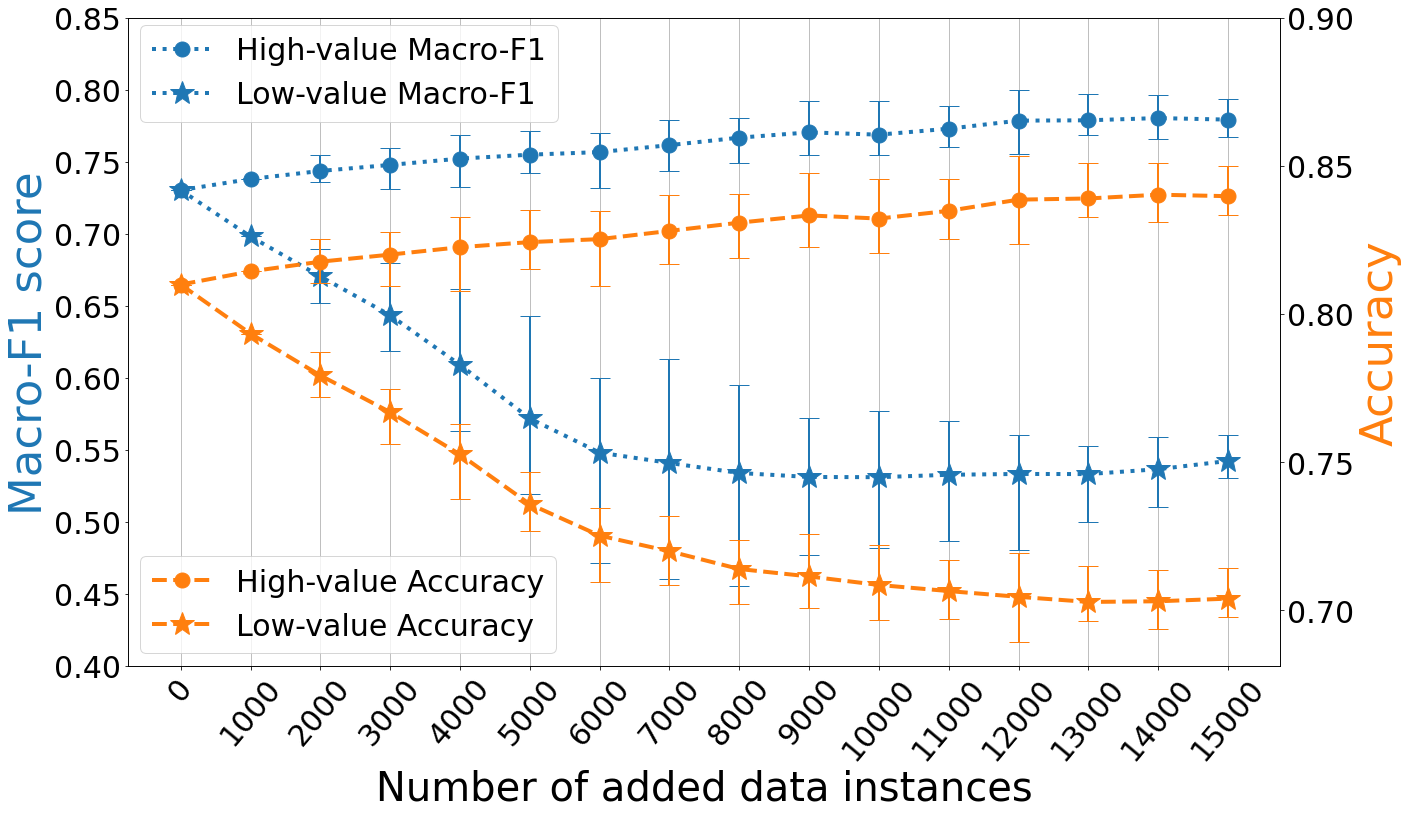

In [27]:
np.set_printoptions(precision=2)


fig1 = plt.figure()

ax = fig1.add_axes([0,0,1,1])
xdata =np.linspace(0,15000,16)
xdata2 =np.linspace(0,15000,16)
plt.rcParams["figure.figsize"] = (16,9)
# plt.xticks(x,values)
plt.xticks(xdata,size =30,rotation = 50)


yerr=[err_max_ma_va,err_min_ma_va]
ax.plot(xdata,ma_va,linewidth=4.0,label="High-value Macro-F1",color='C0',marker='o',ms=15,linestyle=':')
ax.errorbar(xdata, ma_va, yerr=yerr,fmt='o', linewidth=2, capsize=10,color='C0')

yerr1=[err_max_l_ma_va,err_min_l_ma_va]
ax.plot(xdata2,l_ma_va,linewidth=4.0,label ="Low-value Macro-F1",color = 'C0',marker='*',ms=25,linestyle=':')
ax.errorbar(xdata, l_ma_va, yerr=yerr1,fmt='o', linewidth=2, capsize=10,color = 'C0')

ax.set_ylabel('Macro-F1 score',fontsize = 45, color = 'C0')
ax.set_xlabel('Number of added data instances',fontsize = 40)
ax.legend(fontsize = 30,loc =[0.01,0.84])
# ax.set_title('Model performance',fontsize=35)
ysticks =np.arange(0.4,0.9,0.05)
plt.yticks(ysticks,size = 30)
ax.grid(axis='x')



ax1 = ax.twinx()
yerr2=[err_max_va_va,err_min_va_va]
ax1.plot(xdata,va_va,linewidth=4,label="High-value Accuracy",color='C1',marker='o',ms=15,linestyle='--')
ax1.errorbar(xdata, va_va, yerr=yerr2,fmt='o', linewidth=2, capsize=10,color = 'C1')


yerr3=[err_max_l_va_va,err_min_l_va_va]
ax1.plot(xdata2,l_va_va,linewidth=4,label ="Low-value Accuracy",color = 'C1',marker='*',ms=25,linestyle='--')
ax1.errorbar(xdata, l_va_va, yerr=yerr2,fmt='o', linewidth=2, capsize=10,color = 'C1')
ax1.set_ylabel('Accuracy', fontsize = 45, color = 'C1')
ax1.legend(fontsize = 30,loc =[0.01,0.02],handlelength=2)
ysticks =np.arange(0.70,0.9,0.05)
plt.yticks(ysticks,size = 30)


fig1.figure.savefig('./Downloads/mode2_performance.jpg',dpi=600,bbox_inches = 'tight')




